In [1]:
import sys, os, glob
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
from astropy.io import fits
from inverse_problem import HinodeME
from inverse_problem import SpectrumDataset, PregenSpectrumDataset, make_loader
from inverse_problem.nn_inversion.model_mlp_common import MlpCommonNet
from inverse_problem.nn_inversion.posthoc import compute_metrics, open_param_file, plot_params, plot_pred_vs_refer
from inverse_problem.nn_inversion import mlp_transform_rescale, normalize_spectrum
from tqdm import tqdm

## Датасет

Данные и немножко визаулизации

In [3]:
filename = '../data/parameters_base.fits'
transform = None
sobj = SpectrumDataset(param_path=filename, source='database', transform=transform)
sample = sobj[1]

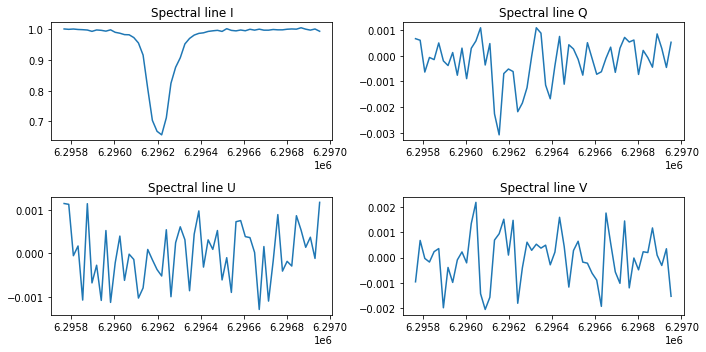

In [4]:
line_type = ['I','Q','U','V']
line_arg = 1000 * (np.linspace(6302.0692255, 6303.2544205, 56)) - 6302.5
fig, ax = plt.subplots(2,2, figsize = (10,5))
for i in range(4):
    ax[i//2][i%2].plot(line_arg, sample['X'][0][:,i]); ax[i//2][i%2].set_title(f'Spectral line {line_type[i]}')
fig.set_tight_layout(tight = True)

### Загрузка лоадера
Показаны два варианта: под вход полносвязной сети и под сверточный блок. Здесь же стоит определиться со всеми преобразованиями данных

In [5]:
MLP  = True
factors, cont_scale = [1,1000,1000,1000], 40000
angle_transformation, logB = True, True



if MLP:
    transform_name = "mlp_transform_rescale"
    batch_size = 20
    train_loader, val_loader = make_loader(filename=filename, transform_name=transform_name, 
                                           factors = factors, cont_scale = cont_scale, 
                                           logB = logB, angle_transformation = angle_transformation, 
                                           batch_size=128)
    sample_batch = next(iter(train_loader))
    print(sample_batch['X'][0].shape, sample_batch['X'][1].shape, sample_batch['Y'].shape)
else:
    transform_name = "conv1d_transform_rescale"
    batch_size = 128
    train_loader, val_loader = make_loader(filename=filename, transform_name=transform_name, 
                                           factors = factors, cont_scale = cont_scale, 
                                           logB = logB, angle_transformation = angle_transformation, 
                                           batch_size=128)
    sample_batch = next(iter(train_loader))
    print(sample_batch['X'][0].shape, sample_batch['X'][1].shape, sample_batch['Y'].shape)
    

torch.Size([128, 224]) torch.Size([128, 1]) torch.Size([128, 11])


можно загружать лоадер из массива, сейчас сделано так, чтобы на небольшом кусочке учить и быстро проиграть тетрадку

In [6]:
param_array = fits.open(filename)[0].data[:500000]
transform_name = "mlp_transform_rescale"
train_loader, val_loader = make_loader(data_arr=param_array, transform_name=transform_name, 
                                       factors = factors, cont_scale= cont_scale,
                                       angle_transformation = angle_transformation, logB = logB, 
                                       batch_size=128)
sample_batch = next(iter(train_loader))
print(sample_batch['X'][0].shape, sample_batch['X'][1].shape, sample_batch['Y'].shape)
print(f"Number of batches for train: {len(train_loader)}, for validation: {len(val_loader)}")

torch.Size([128, 224]) torch.Size([128, 1]) torch.Size([128, 11])
Number of batches for train: 3516, for validation: 391


## Загрузка (определение) модели

In [7]:
model = MlpCommonNet(input_dim=224, output_dim=11, hidden_dims=[200, 200, 100],
                           activation='elu', batch_norm=True, dropout=0.05, number_readout_layers=2);

In [8]:
print(model)

MlpCommonNet(
  (mlp): MLPBlock(
    (FC_layers): ModuleList(
      (0): MLPlayer(
        (linear): Linear(in_features=224, out_features=200, bias=True)
        (batch_normx): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout): Dropout(p=0.05, inplace=False)
      )
      (1): MLPlayer(
        (linear): Linear(in_features=200, out_features=200, bias=True)
        (batch_normx): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout): Dropout(p=0.05, inplace=False)
      )
      (2): MLPlayer(
        (linear): Linear(in_features=200, out_features=100, bias=True)
        (batch_normx): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout): Dropout(p=0.05, inplace=False)
      )
    )
  )
  (readout): MLPReadout(
    (FC_layers): ModuleList(
      (0): MLPlayer(
        (linear): Linear(in_features=101, out_features=50, bias=True)
        (batch_normx)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.99))
model.to(device);

In [10]:
def fit_step(dataloader, max_steps = None):
    """ шаг обучения
        max_steps(int): параметр добавлен для тестовых запусках, весь датасет несколько миллионов спектров, 
        мы тут рукотворно режем число батчей 
    """
    train_loss = 0.0
    train_it = 0    
    if max_steps is None:
        max_steps = float('inf')
    total = min(max_steps,len(dataloader))
    with tqdm(desc="batch", total=total, position=0, leave=True) as pbar_outer:
        for i, inputs in enumerate(dataloader):
            if i==total:
                break
            x = [inputs['X'][0].to(device), inputs['X'][1].to(device)]
            y = inputs['Y'].to(device)
               
            outputs = model(x)
            
            optimizer.zero_grad()
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_it += 1
            if train_it % 10 == 0:
                pbar_outer.update(10)
        return train_loss / train_it
def eval_step(dataloader):
    model.eval()
    val_loss = 0.0
    val_it = 0
    for i, inputs in enumerate(dataloader):
        x = [inputs['X'][0].to(device), inputs['X'][1].to(device)]
        y = inputs['Y'].to(device)
        with torch.no_grad():
            outputs = model(x)
            loss = criterion(outputs, y)
            val_loss += loss.item()
            val_it += 1
    return val_loss / val_it    

In [11]:
%%time
#!!! Когда будете уже учить по настоящему ставьте None
max_steps = 500 #None
best_valid_loss = float('inf')
history = []
log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} val_loss {v_loss:0.4f}"
n_epochs = 2
with tqdm(desc="epoch", total = n_epochs, position=0, leave=True) as pbar_outer:
    for epoch in range(n_epochs):
        train_loss = fit_step(train_loader, max_steps = max_steps)
        val_loss = eval_step(val_loader)
        history.append((train_loss, val_loss))
        pbar_outer.update(1)
        tqdm.write(log_template.format(ep=epoch + 1, t_loss=train_loss,
                                               v_loss=val_loss))
        

epoch:  50%|███████████████████                   | 1/2 [01:21<01:21, 81.80s/it]


Epoch 001 train_loss: 0.6535 val_loss 0.2188


epoch: 100%|██████████████████████████████████████| 2/2 [02:42<00:00, 81.15s/it]


Epoch 002 train_loss: 0.0127 val_loss 0.0100
CPU times: user 2min 40s, sys: 6.24 s, total: 2min 46s
Wall time: 2min 42s


## Анализ модели
Здесь у нас есть две варианта: смотрим как сеть научилась понимать симуляции и как мы переносим модель на реальную жизнь. Для честной оценки архитектуры нам понадобятся симуляции, а в бою - реальные спектры. На Hinode есть и то (реферер) и другое (https://csac.hao.ucar.edu/fg_download.php) (реальный спектры): восстановленные параметры и реальные спектры для них. Они отличаются от того, что мы использовали, но мы про это пока не будем думать

### Реферер 
Посмотрим что он из себя представляет (на самом деле база с параметрами и есть композиция нескольких рефереров)

Несколько примеров лежат подготовленные на гугл диске:
https://drive.google.com/drive/folders/1bv-KLMI67kiGNxlOjkJha2UmVggjV-sa?usp=sharing

In [12]:
path_to_refer = '../data/hinode_source/20140926_170005.fits'
#можно с помощью функции сразу нормировать выходы так как это делается для сети, но посмотреть мы можем и сырые данные
data, names = open_param_file(path_to_refer, normalize=True, angle_transformation = angle_transformation, logB = logB)
print(data.shape)


Open file with 36 available parameters, 11 will be selected
Field_Strength
Field_Inclination
Field_Azimuth
Doppler_Width
Damping
Line_Strength
Source_Function
Source_Function_Gradient
Doppler_Shift2
Stray_Light_Fill_Factor
Stray_Light_Shift
(512, 873, 11)


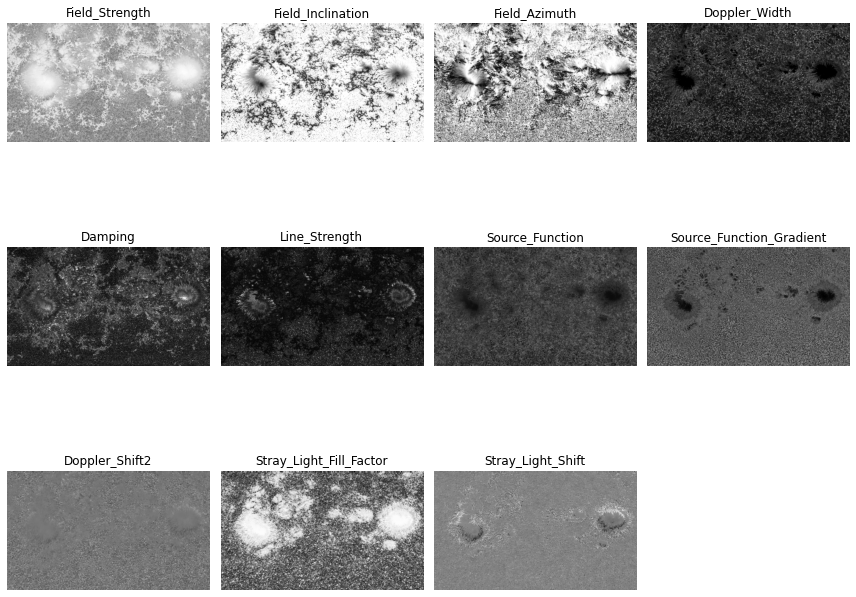

In [13]:
plot_params(data, names=names)

### Тестируем модель на симуляции данных из реферера

тут нам препроцессинг может упростить PregenDataset, можно и руками с помощью  BatchMe приготовить данные (он там и есть). Дальше надо загрузить 500k параметров и сделать симуляцию, поэтому работает это долго (в SpectrumDataset генерация во время обучения, поэтому надо только считать параметры и это быстро)



In [14]:
%%time
transform = mlp_transform_rescale(factors = factors, angle_transformation=angle_transformation, 
                                  cont_scale=cont_scale, logB = logB)
test_dataset = PregenSpectrumDataset(param_path=path_to_refer, source='refer', transform=transform)


CPU times: user 55 s, sys: 19.9 s, total: 1min 14s
Wall time: 1min 17s


In [15]:
inputs = test_dataset.samples
sim_x = [inputs['X'][0].to(device), inputs['X'][1].to(device)]
y = inputs['Y'].to(device)

In [16]:
%%time

model.eval()
with torch.no_grad():
    predicted = model(sim_x)

CPU times: user 2.7 s, sys: 2.05 s, total: 4.75 s
Wall time: 1.85 s


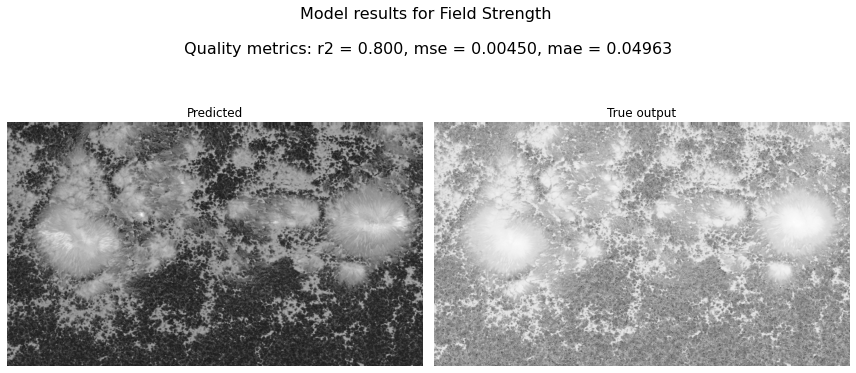

In [17]:
plot_pred_vs_refer(predicted, data, output_index=0)

In [18]:
compute_metrics(data, predicted)

,r2,mse,mae
Field Strength,0.800,0.005,0.050
Field Inclination,0.769,0.018,0.084
Field Azimuth,0.723,0.026,0.109
Doppler Width,0.394,0.019,0.108
Damping,0.418,0.033,0.139
Line Strength,0.230,0.081,0.230
S_0,0.148,0.100,0.298
S_1,0.118,0.069,0.234
Doppler Shift,0.161,0.003,0.042
Filling Factor,0.462,0.044,0.169


## Проверка на реальных спектрах
Спектры лежат в отдельной папочке sp_..... (много папочек в папочках, оставила так же как и лежит на хиноде). Спектры получаются последовательным сканированием щели, и результаты каждой в своем фитсе, всего 873, внутри каждой щели 512 спектров.  

In [19]:
path_to_folder = '../data/hinode_source'
#date as a list with year, month,day, hour 
date = ['2014','09','26','17']
sp_folder = os.path.join(path_to_folder, 'sp_20140926_170005')
sp_path = os.path.join(sp_folder,date[0],date[1],date[2],'SP3D')
sp_path = glob.glob(f'{sp_path}/*/')[0]
sp_lines =  sorted(glob.glob(sp_path+'*.fits'))
print(f'Number of files: {len(sp_lines)}')

Number of files: 873


In [20]:
def open_spectrum_data(sp_folder, date, idx):
    """
    path should start from the folder included in level1 folder, with data year 
    only for this path_to_folder like this sp_20140926_170005
    """
    sp_path = os.path.join(sp_folder,date[0],date[1],date[2],'SP3D')
    sp_path = glob.glob(f'{sp_path}/*/')[0]
    sp_lines =  sorted(glob.glob(sp_path+'*.fits'))
    #print(f'Number of files: {len(sp_lines)}')
    return fits.open(sp_lines[idx])
def real_spectra(spectra_file):
    """
    Extracting and plotting spectral lines from fits
    Why multiply to numbers?
    """
    real_I = spectra_file[0].data[0][:,56:].astype('float64')*2
    real_Q = spectra_file[0].data[1][:,56:].astype('float64')
    real_U = spectra_file[0].data[2][:,56:].astype('float64')
    real_V = spectra_file[0].data[3][:,56:].astype('float64')
    return np.concatenate((real_I, real_Q, real_U, real_V), axis = 1)

In [23]:
def plot_spectrum(sp_folder, date, path_to_refer,  idx_0, idx_1):
    """
    Plot spectrum, corresponding referens values of parameters and model spectrum
    idx_0 - index of line in one spectrum file (512), idx_1 - index of spectrum file sorted by time (873 in total)
    """
    refer, names = open_param_file(path_to_refer, print_params=False, normalize=False)
    spectra_file = open_spectrum_data(sp_folder, date, idx_1)
    real_sp =  real_spectra(spectra_file)
    full_line = real_sp[idx_0,:]
    fig, ax = plt.subplots(2,2, figsize = (10,5))
    line_type = ['I','Q','U','V']
    print('Real spectrum for parameters')
    #print(', '.join([names[i]+f': {refer[idx_0,idx_1, i]:.2f}' for i in range(11)]))
    cont_int = np.max(full_line)

    for i in range(4):
        ax[i//2][i%2].plot(full_line[i*56:i*56+56]/cont_int); ax[i//2][i%2].set_title(f'Spectral line {line_type[i]}')
    fig.suptitle(f'Real spectrum with empiric intensity {cont_int :.1f}', fontsize = 16, fontweight="bold")
    fig.set_tight_layout(tight = True)

    return full_line, cont_int

def plot_model_spectrum(refer, idx_0, idx_1):

    param_vec  = refer[idx_0,idx_1, :]
    obj = HinodeME(param_vec)
    profile = obj.compute_spectrum(with_ff=True, with_noise=True)
    fig, ax = plt.subplots(2,2, figsize = (10,5))
    line_type = ['I','Q','U','V']
    print('Model spectrum for parameters')
    print(', '.join([names[i]+f': {refer[idx_0,idx_1, i]:.2f}' for i in range(11)]))

    for i in range(4):
        ax[i//2][i%2].plot(profile[0,:,i]); ax[i//2][i%2].set_title(f'Spectral line {line_type[i]}')
    fig.set_tight_layout(tight = True)
    fig.suptitle(f'Model spectrum with estimated intensity {obj.cont:.1f}', fontsize = 16, fontweight="bold")

    return profile, obj.cont    

Real spectrum for parameters
Model spectrum for parameters
Field_Strength: 302.78, Field_Inclination: 86.39, Field_Azimuth: 105.42, Doppler_Width: 27.02, Damping: 0.22, Line_Strength: 7.18, Source_Function: 7479.19, Source_Function_Gradient: 18128.35, Doppler_Shift2: 0.55, Stray_Light_Fill_Factor: 0.09, Stray_Light_Shift: -0.27


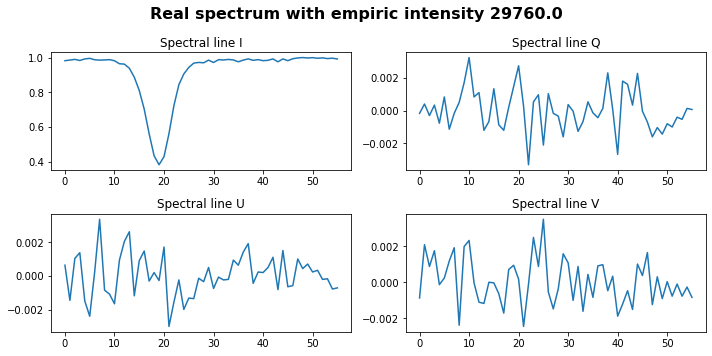

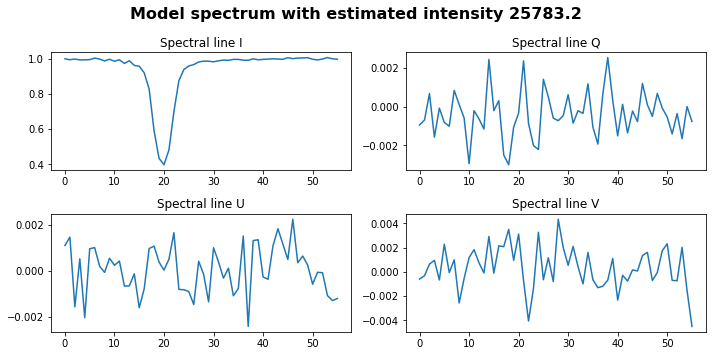

In [29]:
# можно побегать индексами и посравнивать спектры
idx_0, idx_1 = 10, 10
cont_int, real_line = plot_spectrum(sp_folder, date, path_to_refer, idx_0, idx_1)
refer, names = open_param_file(path_to_refer, print_params=False, normalize=False)
profile, cont_int  = plot_model_spectrum(refer, idx_0, idx_1)

In [30]:
def read_spectrum_for_refer(sp_folder, date):
    real_samples = np.zeros((512,873, 224))
    cont = np.zeros((512,873))
    for idx_1 in range(873):
        line = real_spectra(open_spectrum_data(sp_folder, date, idx_1))
        real_samples[:, idx_1,:] = line
        cont[:, idx_1] = np.max(line, axis=1)
    real_samples = real_samples.reshape(-1, 224)  
    cont = cont.reshape(-1,1)
    return real_samples/cont, cont
def prepare_real_mlp(sp_folder, date, factors = None, cont_scale = None, device = None):
    real_samples, cont = read_spectrum_for_refer(sp_folder, date)
    norm_real_samples = normalize_spectrum(np.reshape(real_samples, (-1,56,4), order='F'), factors = factors)
    norm_cont = cont/cont_scale
    norm_real_samples = np.reshape(norm_real_samples, (-1,224), order='F')
    real_x = [torch.from_numpy(norm_real_samples).float().to(device), torch.from_numpy(norm_cont).float().to(device)]
    return real_x
    

In [31]:
%%time
real_x = prepare_real_mlp(sp_folder, date, factors = factors, cont_scale = cont_scale, device = device)

CPU times: user 5.01 s, sys: 2.46 s, total: 7.47 s
Wall time: 9.41 s


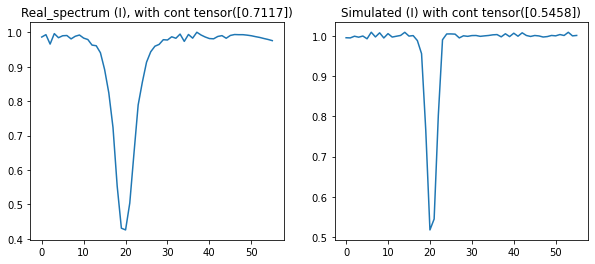

In [33]:
#тоже можно побегать индексом и увидеть, что наши симуляции довольно сильно отличаются
idx = 20
plt.figure(figsize = (10,4))
plt.subplot(1,2,1); plt.plot(real_x[0][idx, :56]); plt.title(f'Real_spectrum (I), with cont {real_x[1][idx]}')
plt.subplot(1,2,2);  plt.plot(sim_x[0][idx, :56]); plt.title(f'Simulated (I) with cont {sim_x[1][idx]}');


In [34]:
model.eval()
with torch.no_grad():
    predicted_real = model(real_x)

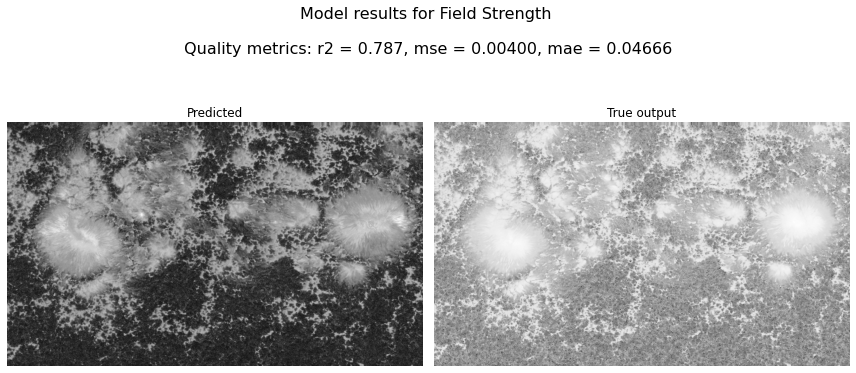

In [35]:
plot_pred_vs_refer(predicted_real, data, output_index=0)